# Chapter 5 - Commmunity Detection

In this notebook, we explore several algorithms to find communities in graphs.

In some cells, we use the ABCD benchmark to generate synthetic graphs with communities. 
ABCD is written in Julia.

### Installing Julia and ABCD

We use the command line interface option to run ABCD below. 
The following steps are required:

* install Julia (we used version 1.7) from https://julialang.org/downloads/
* download ABCD from https://github.com/bkamins/ABCDGraphGenerator.jl
* adjust the 'abcd_path' in the next cell to the location of the 'utils' subdirectory of ABCD
* run 'julia abcd_path/install.jl' to install the required packages

Also set the path(s) in the cell below. For Windows, you may need to use "\\" or "\\\\" as delimiters, for example 'C:\ABCD\utils\\\\'

### Directories

* Set the directories accordingly in the next cell


In [1]:
## set those accordingly
datadir = '../Datasets/'
#abcd_path = '/work/home/fcthebe/ABCDGraphGenerator.jl-master/utils/'
abcd_path = '~/ABCD/utils/'
#julia = '/work/home/fcthebe/julia-1.7.2/bin/julia '
julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ' ## you may need the full path here


In [2]:
## uncomment to get wide display
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random 
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

## we use those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['white','gray','dimgray','black']

# Zachary (karate) graph

This is a small graph with 34 nodes and two ground-truth communities.
Modularity-based algorithms will typically find 4 or 5 communities.
In the next cells, we look at this small graph from several different angles.


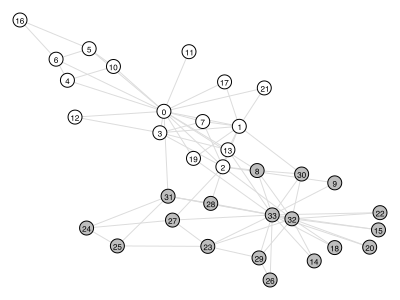

In [4]:
random.seed(12345)
g_zac = ig.Graph.Famous('zachary')
g_zac.vs['size'] = 14
g_zac.vs['label'] = g_zac.vs['name'] = [str(i) for i in range(g_zac.vcount())]
g_zac.vs['label_size'] = 8
g_zac.es['color'] = cls_edges
g_zac.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
g_zac.vs['color'] = [cls[i] for i in g_zac.vs['comm']]
ly_zac = g_zac.layout_fruchterman_reingold() 
#ig.plot(g_zac, 'zachary_gt.eps', layout = ly_zac, bbox=(0,0,400,300))
ig.plot(g_zac, layout = ly_zac, bbox=(0,0,400,300))

## Node Roles
 
We compute $z(v)$ (normalized within module degree) and $p(v)$ (participation coefficients) as defined in section 5.2 of the book for the Zachary graph `g_zac`. We identify 3 types of nodes, as described in the book.

* provincial hubs
* peripheral nodes (non-hubs)
* ultra peripheral nodes (non-hubs)
    

In [5]:
## normalized within-module degree (z(v))
def nwmd(G, A):
    # within module degrees
    deg_in = [sum([A[v] == A[i] for i in G.neighbors(v)]) for v in range(G.vcount())]
    deg_in_mean = [ np.mean([deg_in[i] for i in range(G.vcount()) if A[i] == j]) for j in set(A) ]
    deg_in_std = [ np.std([deg_in[i] for i in range(G.vcount()) if A[i] == j], ddof=1) for j in set(A) ]
    return [ (deg_in[v]-deg_in_mean[A[v]]) / deg_in_std[A[v]] for v in range(G.vcount()) ]

## participation coefficient
def pc(G, A):
    deg = G.degree()
    coef = []
    for v in range(G.vcount()):
        coef.append(1-np.sum([(x/deg[v])**2 for x in Counter([A[i] for i in G.neighbors(v)]).values()]))
    return coef


In [6]:
## compute z (normalized within-module degree) and p (participation coefficient)
g_zac.vs['z'] = nwmd(g_zac, g_zac.vs['comm'])
g_zac.vs['p'] = pc(g_zac, g_zac.vs['comm']) 

## store the results and sort
D = pd.DataFrame(np.array([g_zac.vs['z'],g_zac.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head()


,z,p
33,3.133291,0.207612
0,3.104691,0.218750
32,2.005306,0.152778
1,1.218296,0.197531
3,0.589498,0.000000


### Looking at $z(v)$ and $p(v)$

Below, we plot the Zachary graph with respect to $z(v)$ where $z(v) > 2.5$ are **hubs**, which we show as **white square** nodes.

The largest values are for node 0 (instructor), node 33 (president) and node 32.
Nodes 0 and 33 are the key nodes for the division of the group into factions.

The **ultra-peripherial** nodes are shown with darker color.


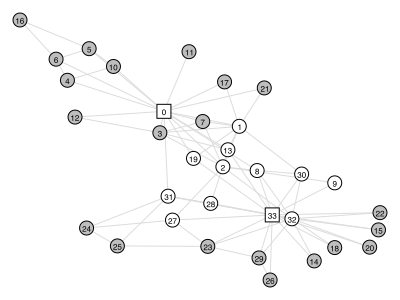

In [7]:
## Zachary graph w.r.t. roles
g_zac.vs['color'] = cls[3]
g_zac.vs['shape'] = 'circle'
for v in g_zac.vs:
    if v['z'] < 2.5: ## non-hub
        if v['p'] < .62 and v['p'] >= .05: ## peripheral
            v['color'] = cls[0]
        if v['p'] < .05: ## ultra-peripheral
            v['color'] = cls[1]
    if v['z'] >= 2.5 and v['p'] < .3: ## hubs (all provincial here)            
        v['color'] = cls[0]
        v['shape'] = 'square'
#ig.plot(g_zac, 'zachary_roles_1.eps', layout=ly_zac, bbox=(0,0,400,300))
ig.plot(g_zac, layout=ly_zac, bbox=(0,0,400,300))

### Figure 5.3(b)

The code below is to generate Figure 5.3(b) in the book, again comparing node roles in the Zachary graph.


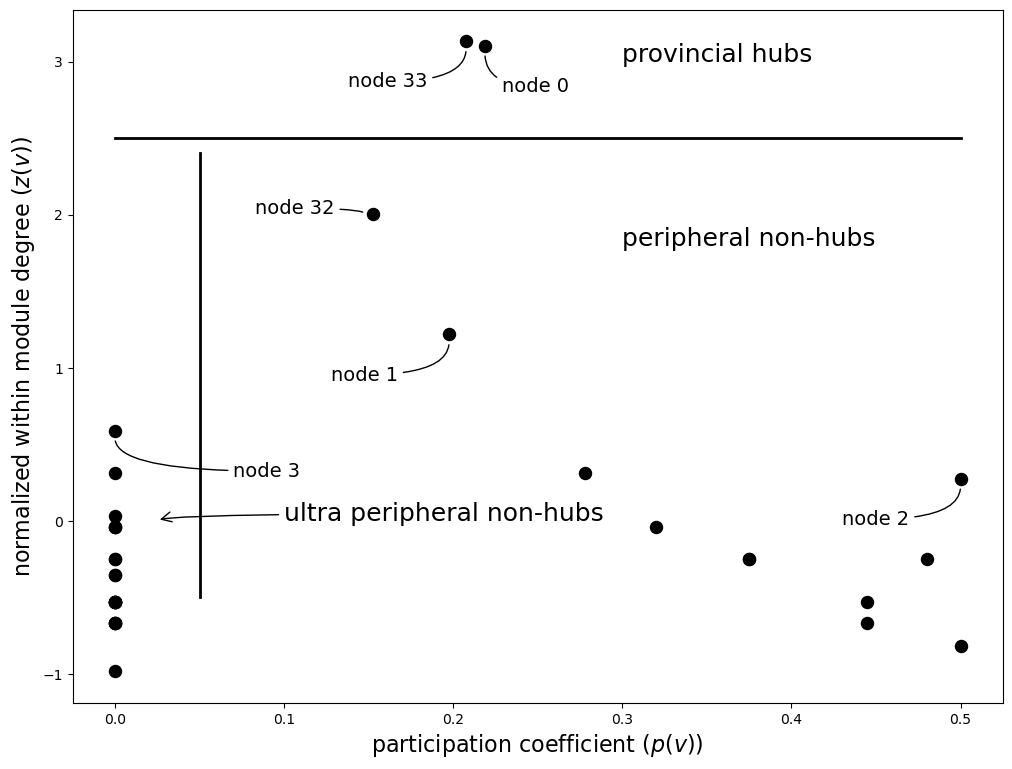

In [8]:
## Figure 5.3(b) -- comparing the roles
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(g_zac.vs['p'],g_zac.vs['z'],marker='o',s=75, color='k')

plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
plt.plot([.05, .05], [-.5, 2.4], color='k', linestyle='-', linewidth=2)

ax.annotate('node 0', (g_zac.vs['p'][0],g_zac.vs['z'][0]-.05), xytext=(g_zac.vs['p'][0]+.01,g_zac.vs['z'][0]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 33', (g_zac.vs['p'][33],g_zac.vs['z'][33]-.05), xytext=(g_zac.vs['p'][33]-.07,g_zac.vs['z'][33]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 32', (g_zac.vs['p'][32]-.005,g_zac.vs['z'][32]), xytext=(g_zac.vs['p'][32]-.07,g_zac.vs['z'][32]), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 1', (g_zac.vs['p'][1],g_zac.vs['z'][1]-.05), xytext=(g_zac.vs['p'][1]-.07,g_zac.vs['z'][1]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 3', (g_zac.vs['p'][3],g_zac.vs['z'][3]-.05), xytext=(g_zac.vs['p'][3]+.07,g_zac.vs['z'][3]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 2', (g_zac.vs['p'][2],g_zac.vs['z'][2]-.05), xytext=(g_zac.vs['p'][2]-.07,g_zac.vs['z'][2]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('provincial hubs',(.3,3), fontsize=18)
ax.annotate('peripheral non-hubs',(.3,1.8), fontsize=18)
ax.annotate('ultra peripheral non-hubs',(0.025,0.0),xytext=(.1,0), fontsize=18,
             arrowprops = dict( arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))

plt.xlabel(r'participation coefficient ($p(v)$)',fontsize=16)
plt.ylabel(r'normalized within module degree ($z(v)$)',fontsize=16);
#plt.savefig('zachary_roles_2.eps')

### Looking at a few other community-based features

We already saw the *normalized within-module degree* $z(v)$ and *participation coefficient* $p(v)$.

Recall that a high value for $z(v)$ is indicative of a hub. For $p(v)$, a value close to zero indicates homogeneity of communities amongst $v$'s neighbours, while a high value indicates heterogeneity.

Below we compute the *community distribution distance* (cdd) and the *community association strength* (cas).

In [9]:
## community distribution distance
def cdd(G, A):
    deg = G.degree()
    Vol = sum(deg)
    Vol_A = np.zeros(max(A)+1, dtype='int')
    for i in range(G.vcount()):
        Vol_A[A[i]] += deg[i]
    Vol_A = Vol_A/Vol
    cdd = []
    for i in range(G.vcount()):
        deg_A = np.zeros(max(A)+1, dtype='int')
        for v in G.neighbors(i):
            deg_A[A[v]]+=1
        cdd.append(np.sqrt( sum( (deg_A/deg[i]-Vol_A)**2 )))
    return cdd

## community association strength
def cas(G,A):
    deg = np.array(G.degree())
    deg_int = np.array([sum([A[i] == A[j] for i in G.neighbors(j)]) for j in range(G.vcount())])
    Vol = sum(deg)
    Vol_A = np.zeros(max(A)+1, dtype='int')
    for i in range(G.vcount()):
        Vol_A[A[i]] += deg[i]
    return deg_int/deg - (np.array([Vol_A[A[i]] for i in range(G.vcount())]) - deg)/Vol

g_zac.vs['cdd'] = cdd(g_zac, g_zac.vs['comm'])
g_zac.vs['cas'] = cas(g_zac, g_zac.vs['comm'])


Below we show the nodes with low *cas* values with white color. We see that those correspond to nodes that are at the bourdary between communities.

We also compute the Pearson correlation coefficient between the community-based measures we computed.


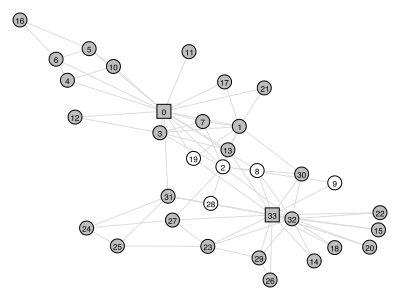

In [10]:
## value with lowest 'cas' are shown in white
th = np.quantile(g_zac.vs['cas'], .15)
g_zac.vs['color'] = [cls[int(i)] for i in np.array(g_zac.vs['cas'])>th]
ig.plot(g_zac, layout=ly_zac, bbox=(0,0,400,300))

In [11]:
## correlation between various community-based measures
np.corrcoef([g_zac.vs['z'],g_zac.vs['p'],g_zac.vs['cdd'],g_zac.vs['cas']])


array([[ 1.        ,  0.13862258, -0.04548086,  0.11574193],
       [ 0.13862258,  1.        , -0.97569403, -0.94589871],
       [-0.04548086, -0.97569403,  1.        ,  0.9860772 ],
       [ 0.11574193, -0.94589871,  0.9860772 ,  1.        ]])

## Strong and weak communities

Communities can be defined as strong or weak as per (5.1) and (5.2) in the book.

For the Zachary graph, we verify if nodes within communities satisfy the strong criterion, then we verify is the two communities satisfy the weak definition.

For the strong definition (internal degree larger than external degree for each node), only two nodes do not qualify: nodes 2 and 9.

For the weak definition (total community internal degree > total community external degree), both communities satisfy this criterion.


In [12]:
## strong criterion
for i in range(g_zac.vcount()):
    c = g_zac.vs[i]['comm']
    n = [g_zac.vs[v]['comm']==c for v in g_zac.neighbors(i)]
    if sum(n)<=len(n)-sum(n):
        print('node',i,'has internal degree',sum(n),'external degree',len(n)-sum(n))

node 2 has internal degree 5 external degree 5
node 9 has internal degree 1 external degree 1


In [13]:
## weak criterion
I = [0,0]
E = [0,0]
for i in range(g_zac.vcount()):
    c = g_zac.vs[i]['comm']
    n = [g_zac.vs[v]['comm']==c for v in g_zac.neighbors(i)]
    I[c] += sum(n)
    E[c] += len(n)-sum(n)
print('community 0 internal degree',I[0],'external degree',E[0])
print('community 1 internal degree',I[1],'external degree',E[1])


community 0 internal degree 66 external degree 10
community 1 internal degree 70 external degree 10


## Hierarchical clustering and dendrogram

Girvan-Newman algorithm is described in section 5.5 of the book. We apply it to the Zachary graph and show the results of this divisive algorithm as a dendrogram.


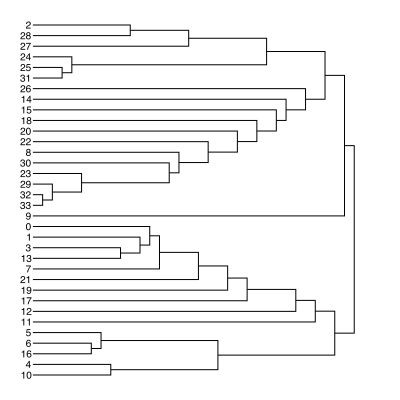

In [14]:
## Girvan-Newman algorithm
gn = g_zac.community_edge_betweenness()
#ig.plot(gn,'zachary_dendrogram.eps',bbox=(0,0,400,400))
ig.plot(gn,bbox=(0,0,400,400))

This is an example of a hierarchical clustering. In the next plot, we compute modularity for each possible cut of the dendrogram.

We see that we get strong modularity with 2 clusters, but maximal value is obtained with 5.


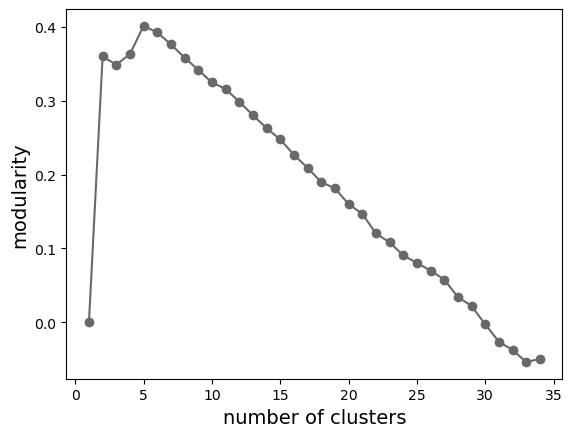

In [15]:
## compute modularity at each possible cut and plot
q = []
for i in np.arange(g_zac.vcount()):
    q.append(g_zac.modularity(gn.as_clustering(n=i+1)))
plt.plot(np.arange(1,1+g_zac.vcount()), q, 'o-', color=cls[2])
plt.xlabel('number of clusters',fontsize=14)
plt.ylabel('modularity',fontsize=14);
#plt.savefig('zachary_modularity.eps');

How are the nodes partitioned if we pick only 2 communities? How does this compare to the underlying ground truth?

From the plot below, we see that only 1 node is misclassified (node 2 was "white" in the plot with ground-truth communities)

The modularity of this partition, $q = 0.35996$. 

We also compare the partition with ground truth via AMI (adjusted mutual information), as defined in section 5.3 of the book; we got a high value AMI = 0.83276 showing  strong concordance. 


AMI: 0.8327564079186137
q: 0.3599605522682446


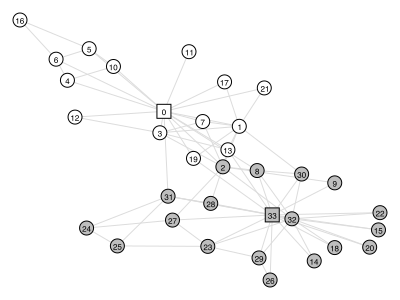

In [16]:
## show result with 2 clusters -- 
g_zac.vs['gn'] = gn.as_clustering(n=2).membership
print('AMI:',AMI(g_zac.vs['comm'],g_zac.vs['gn']))  ## adjusted mutual information
print('q:',g_zac.modularity(g_zac.vs['gn']))        ## modularity
g_zac.vs['label_size'] = 8
g_zac.vs['color'] = [cls[i] for i in g_zac.vs['gn']]
#ig.plot(g_zac, 'zachary_2.eps', layout=ly_zac, bbox=(0,0,400,300))
ig.plot(g_zac, layout=ly_zac, bbox=(0,0,400,300))

Below we show the same plot as above, but we label the nodes with respect to the 5 communities found by modularity-based algorithms. 

We color the nodes with respect to the two ground-truth communities.

We indeed see that in that case, we get higher modularity, but weaker AMI value.

Other than breaking up each community in two, we see that node 2 is mis-labelled (as already noticed), and node 9 is isolated in its own community (community #4). 

Recall that those were the only two nodes **not** having **strong connectivity** with respect to the ground truth communities.


AMI: 0.5499173029289166
q: 0.40129848783694944


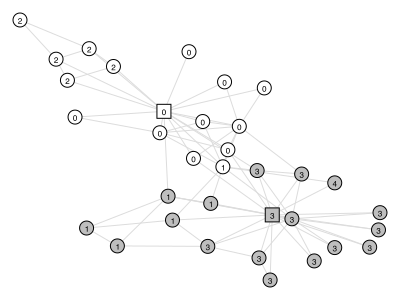

In [17]:
## show result with optimal modularity (5 clusters)
g_zac.vs['label'] = gn.as_clustering(n=5).membership
print('AMI:',AMI(g_zac.vs['comm'],g_zac.vs['label']))
print('q:',g_zac.modularity(g_zac.vs['label']))
g_zac.vs['color'] = [cls[i] for i in g_zac.vs['comm']]
#ig.plot(g_zac, 'zachary_5.eps', layout=ly_zac, bbox=(0,0,400,300))
ig.plot(g_zac, layout=ly_zac, bbox=(0,0,400,300))

# ABCD graph with 100 nodes

Next we look at a slightly larger graph generated with the ABCD benchmark model, which is described in section 5.3 of the book. This graph has 3 communities. 
Using hierarchical clustering, we compare modularity and AMI for each possible cut.

The ABCD parameters used to generate this graph are: 
* $\gamma=3$
* $\tau=2$
* degree range [5,15]
* community size range [25,50]
* $\xi=.2$.

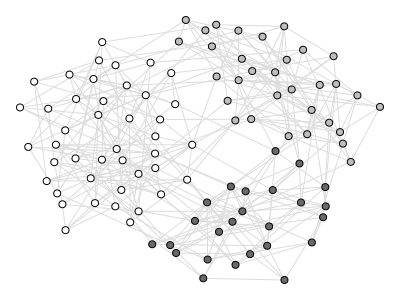

In [18]:
## read graph and communities 
g_abcd = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_100_comms.dat',dtype='uint16',usecols=(1))
g_abcd.vs['comm'] = [c[int(x['name'])-1]-1 for x in g_abcd.vs]
gt = {k:(v-1) for k,v in enumerate(g_abcd.vs['comm'])}

## map between int(name) to key
n2k = {int(v):k for k,v in enumerate(g_abcd.vs['name'])}

## plot
g_abcd.vs['size'] = 7
g_abcd.es['color'] = cls_edges
g_abcd.vs['color'] = [cls[i] for i in g_abcd.vs['comm']]
ig.plot(g_abcd, bbox=(0,0,400,300))

### Girvan-Newman algorithm

We plot the modularity and AMI for each cut from the GN algorithm.

In this case, both modularity and AMI are maximized with 3 communities.


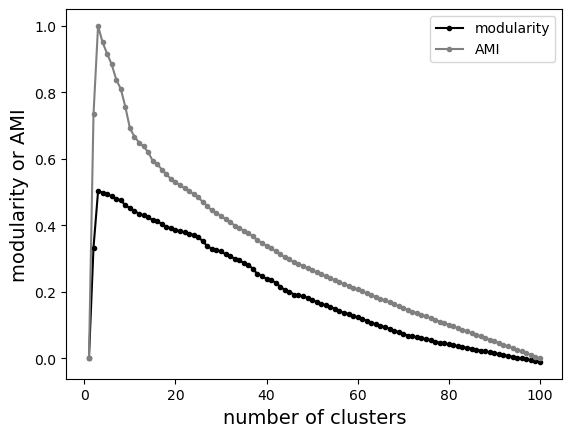

In [19]:
q = []
a = []
gn = g_abcd.community_edge_betweenness()
for i in np.arange(g_abcd.vcount()):
    q.append(g_abcd.modularity(gn.as_clustering(n=i+1)))
    a.append(AMI(g_abcd.vs['comm'],gn.as_clustering(n=i+1).membership))
plt.plot(np.arange(1,1+g_abcd.vcount()),q,'.-',color='black',label='modularity')
plt.plot(np.arange(1,1+g_abcd.vcount()),a,'.-',color='grey',label='AMI')
plt.xlabel('number of clusters',fontsize=14)
plt.ylabel('modularity or AMI',fontsize=14)
plt.legend();
#plt.savefig('abcd_dendrogram.eps');

We see that with 3 communities, $q=0.502$ and AMI=1, so perfect recovery.


In [20]:
n_comm = np.arange(1,g_abcd.vcount()+1)
D = pd.DataFrame(np.array([n_comm, q, a]).transpose(),columns=['n_comm','q','AMI'])
df = D.head(10)
df

,n_comm,q,AMI
0,1.0,0.000000,0.000000
1,2.0,0.333078,0.733860
2,3.0,0.502257,1.000000
3,4.0,0.498567,0.950319
4,5.0,0.493682,0.916139
5,6.0,0.487273,0.883976
6,7.0,0.479490,0.838212
7,8.0,0.475531,0.810064
8,9.0,0.460012,0.755964
9,10.0,0.451645,0.691837


What would we get with 4 clusters, for which AMI = 0.95 is also quite high?
We see below that we have a few nodes splitted from one community.

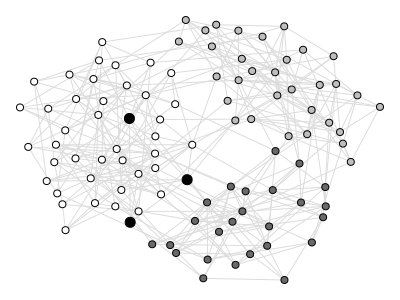

In [21]:
## 4 communities
g_abcd.vs['gn'] = gn.as_clustering(n=4).membership
for v in np.where(np.array(g_abcd.vs['gn'])==3):
    g_abcd.vs[v]['size'] = 10
g_abcd.vs['color'] = [cls[i] for i in g_abcd.vs['gn']]
ly = g_abcd.layout()
#ig.plot(g_abcd, 'abcd_4.eps', bbox=(0,0,400,300))
ig.plot(g_abcd, layout=ly, bbox=(0,0,400,300))

Those splitted nodes actually form a triangle.


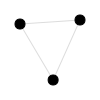

In [22]:
sg = g_abcd.subgraph([v for v in g_abcd.vs() if v['gn']==3])
ig.plot(sg, bbox=(0,0,100,100))

### ABCD graph with outliers


In [23]:
## read graph and communities 
g_abcd_o = ig.Graph.Read_Ncol(datadir+'ABCD/abcd+o_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd+o_100_comms.dat',dtype='uint16',usecols=(1))
g_abcd_o.vs['comm'] = [c[int(x['name'])-1]-1 for x in g_abcd_o.vs]
random.seed(123)
g_abcd_o.vs['ecg'] = g_abcd_o.community_leiden(objective_function='modularity').membership

## community-based features for outlier and other nodes
df = pd.DataFrame(g_abcd_o.vs['comm'], columns=['community'])
df['cdd'] = cdd(g_abcd_o, g_abcd_o.vs['ecg'])
df['cas'] = cas(g_abcd_o, g_abcd_o.vs['ecg'])
df['pc'] = pc(g_abcd_o, g_abcd_o.vs['ecg'])
df.groupby(by='community').quantile([.25,.75])


cdd       cas        pc
community                                   
0         0.25  0.274602  0.205925  0.465000
          0.75  0.436317  0.337661  0.606771
1         0.25  0.568665  0.463295  0.197531
          0.75  0.668872  0.557964  0.320000
2         0.25  0.573724  0.454624  0.000000
          0.75  0.793414  0.654624  0.320000
3         0.25  0.625769  0.503757  0.000000
          0.75  0.853096  0.703757  0.320000

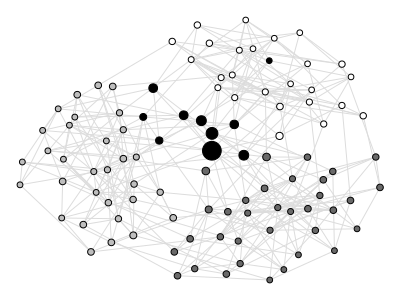

In [24]:
## plot - node size proportional to participation coefficient
g_abcd_o.vs['size'] = [4+1.2/x for x in df['cas']]
g_abcd_o.es['color'] = cls_edges
g_abcd_o.vs['color'] = [cls[(3-i)%4] for i in g_abcd_o.vs['comm']]
ig.plot(g_abcd_o, bbox=(0,0,400,300))
#ig.plot(g_abcd_o, 'abcd+o.eps', bbox=(0,0,400,300))


# ABCD with varying $\xi$

Here we show a typical way to compare graph clustering algorithms using benchmark graphs. 
We pick some model, here ABCD, and we vary the noise parameter $\xi$. 
With ABCD, the larger $\xi$ is, the closer we are to a random Chung-Lu or configuration model graph (i.e. where only the degree distribution matters). For $\xi=0$, we get pure communities (all edges are internal).

For each choice of $\xi$, we generate 30 graphs, apply several different clustering algorithms,
and compute AMI (adjusted mutual information) for each algorithm, comparing with ground-truth communities.

The code below is commented out as it can take a while to run; a pickle file with results is included in the Data directory. To re-run from scratch, uncomment the cell below.

Parameters for the ABCD benchmark graphs are:

* $n=1,000$
* $\gamma=2.5$
* $\tau=1.5$
* degree range [10,50]
* community size range [50,100]
* $0.1 \le \xi \le 0.8$


In [25]:
## load data generated with the code from above cell 
with open(datadir+"ABCD/abcd_study.pkl","rb") as f:
    df = pickle.load(f)
## take average over all runs for each algorithm and every choice of xi
df_avg = df.groupby(by=['algo','xi']).mean()


We plot the results in the following 2 cells. 
We see good results with Leiden and Infomap, and slightly better results with ECG.
Label propagation is a fast algortihm, but it does collapse with moderate to high level of noise.

From the standard deviation plot, we see high variability around the value(s) for $\xi$ where the different
algorithms start to collapse. We see that this happen later and at a smaller scale with EGC, which is known to have good stability.

ECG and Leiden are often good choices for *unweighted* graphs while for *weighted* graphs, Leiden is usually a good option.

Such studies are useful to compare algorithms; using benchmarks, we can directly control parameters such as the noise level.


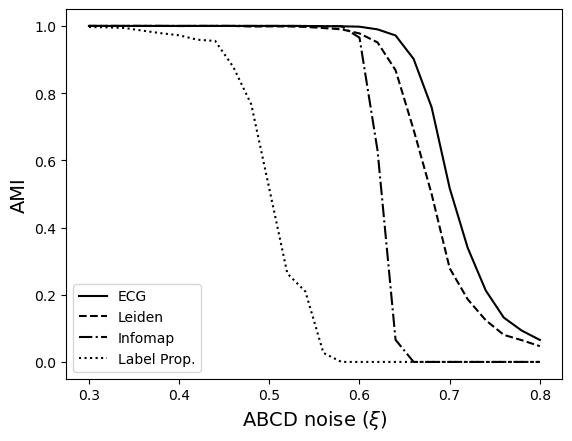

In [26]:
## plot average results foe each algorithm over range of xi
alg = ['ECG', 'Leiden', 'Infomap', 'Label Prop.']
lt = ['-','--','-.',':']
cl = ['blue','green','red','purple']
for i in range(len(alg)):
    ## pick one - color or greyscale
    plt.plot(df_avg.loc[(alg[i])].index, df_avg.loc[(alg[i])], lt[i], label=alg[i], color=cls[3])
    #plt.plot(df_avg.loc[(alg[i])].index, df_avg.loc[(alg[i])], lt[i], label=alg[i], color=cl[i]) ## color plot
plt.xlabel(r'ABCD noise ($\xi$)', fontsize=14)
plt.ylabel('AMI', fontsize=14)
plt.legend();
#plt.savefig('abcd_study.eps');

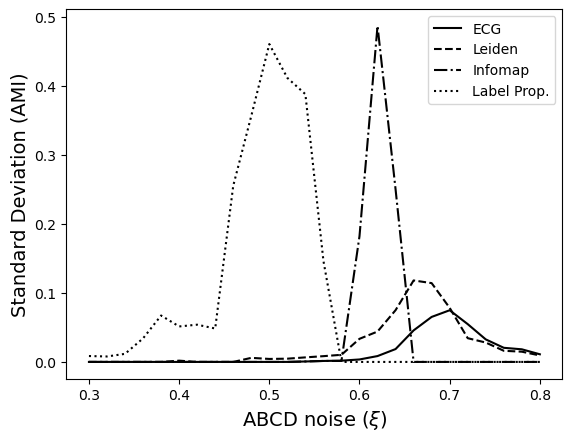

In [27]:
##  Look at standard deviations
S = df.groupby(by=['algo','xi']).std()
alg = ['ECG','Leiden','Infomap','Label Prop.']
lt = ['-','--','-.',':']
cl = ['blue','green','red','purple']
for i in range(len(alg)):
    ## pick one - color of greyscale
    #plt.plot(S.loc[(alg[i])].index,S.loc[(alg[i])],lt[i],label=alg[i],color=cl[i])
    plt.plot(S.loc[(alg[i])].index,S.loc[(alg[i])],lt[i],label=alg[i],color=cls[3])
plt.xlabel(r'ABCD noise ($\xi$)',fontsize=14)
plt.ylabel('Standard Deviation (AMI)',fontsize=14)
plt.legend();
#plt.savefig('abcd_study_stdv.eps');

## Compare stability 

This study is similar to the previous one, but this time we run each algorithm **twice** on each graph, and we compare the similarity for each such pair of partitions, instead of comparing with the ground truth.

Thus we look at the **stability** of the algorithms. 

Note that an algorithm can be stable, but still be bad (ex: always cluster all nodes in a single community).

The code below can take a while to run; a pickle file with results is included in the Data directory. To re-run from scratch, uncomment the cell below.


In [28]:
## load L and train/val/test ids
with open(datadir+"ABCD/abcd_study_stability.pkl","rb") as f:
    df = pickle.load(f)
## take averages for each algorithm and each noise value xi
df_avg = df.groupby(by=['algo','xi']).mean()

We plot the results below. The behaviour of algorithms can be clustered in two groups:

* For Leiden and ECG, stability is excellent and degrades gradually for high noise level.
* For Infomap and Label Propagation, stability is also good until the noise value where the results start to degrade, as we saw in the previous study. We see near perfect stability for very high noise values; those are values where the results were very bad in the previous study; this typically happens when the algorithm can't get any good clustering and returns some trivial partition, such as putting all nodes together in the same community, thus a stable but bad result.


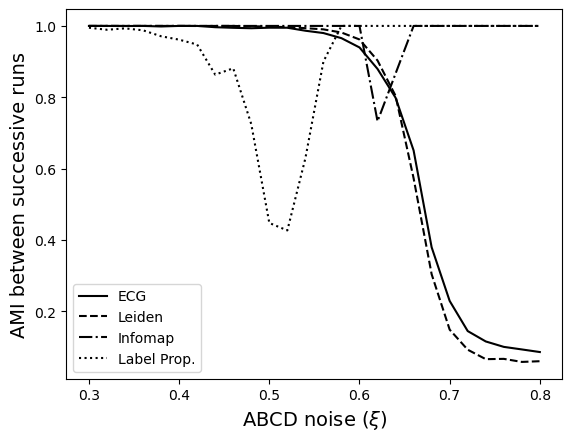

In [29]:
alg = ['ECG','Leiden','Infomap','Label Prop.']
lt = ['-','--','-.',':']
cl = ['blue','green','red','purple']
## pick one - black or color
for i in range(len(alg)):
    plt.plot(df_avg.loc[(alg[i])].index, df_avg.loc[(alg[i])],lt[i], label=alg[i], color=cls[3])
    #plt.plot(df_avg.loc[(alg[i])].index, df_avg.loc[(alg[i])], lt[i], label=alg[i], color=cl[i])
plt.xlabel(r'ABCD noise ($\xi$)',fontsize=14)
plt.ylabel('AMI between successive runs',fontsize=14)
plt.legend();
#plt.savefig('abcd_study_stability.eps');

# Modularity, resolution limit and rings of cliques

We illustrate issues with modularity with the famous ring of cliques examples.

For example below, we have a ring of 3-cliques connected by a single (inter-clique) edge.

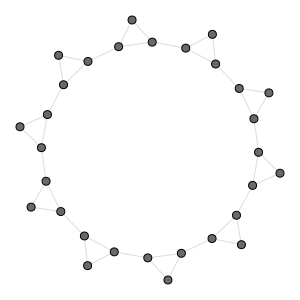

In [30]:
## build a RoC with n cliques of size s
def ringOfCliques(n,s):
    roc = ig.Graph.Erdos_Renyi(n=n*s,p=0)
    ## cliques
    for i in range(n):
        for j in np.arange(s*i,s*(i+1)):
            for k in np.arange(j+1,s*(i+1)):
                roc.add_edge(j,k)
    ## ring
    for i in range(n):
        if i>0:
            roc.add_edge(s*i-1,s*i)
        else:
            roc.add_edge(n*s-1,0)
    roc.vs['size'] = 8
    roc.vs['color'] = cls[2]
    roc.es['color'] = cls_edges
    return roc

## Ex: 10 3-cliques
roc = ringOfCliques(10,3)
#ig.plot(roc,'ring_3.eps',bbox=(0,0,300,300))     
ig.plot(roc,bbox=(0,0,300,300))        

We compare the number of cliques (the natural parts in a partition) with the actual number of communities found via modularity based algorithms Leiden and ECG.

With Leiden as is (i.e. resolution parameter 1.0), we see a smaller number of communities than the number of cliques; 
this is a known problem with modularity: merging cliques in the same community often lead to higher modularity.

One way to alleviate this issue is to increase the **resolution parameter**; with resolution parameter 5 instead of the default value of 1, we see that we can recover 
the cliques in most cases. 

A concensus algorithm like ECG can help a lot in such cases; below we see that all the cliques are correctly recovered.


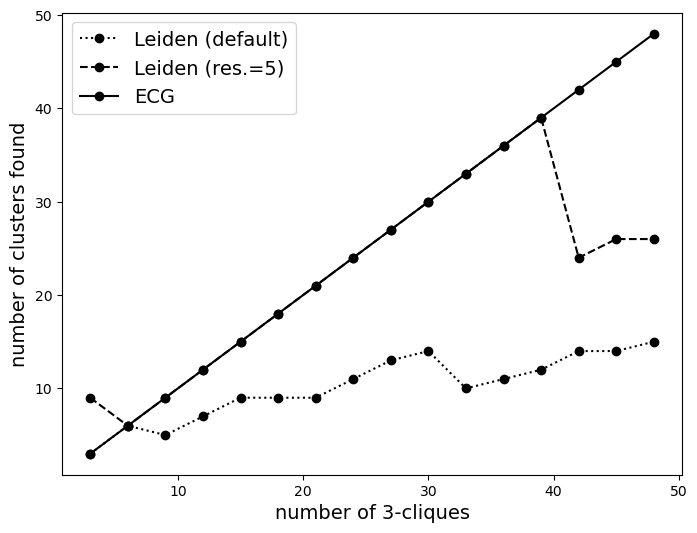

In [31]:
## Compare number of cliques and number of clusters found
L = []
s = 3
for n in np.arange(3,50,3):
    roc = ringOfCliques(n, s)
    le = np.max(roc.community_leiden(objective_function='modularity').membership)+1
    ler = np.max(roc.community_leiden(objective_function='modularity', resolution=5.0).membership)+1
    ec = np.max(roc.community_ecg().membership)+1
    L.append([n,ler,le,ec])
D = pd.DataFrame(L,columns=['n','Leiden_res','Leiden','ECG'])
plt.figure(figsize=(8,6))
plt.plot(D['n'],D['Leiden'],':o',color=cls[3],label='Leiden (default)')
plt.plot(D['n'],D['Leiden_res'],'--o',color=cls[3],label='Leiden (res.=5)')
plt.plot(D['n'],D['ECG'],'-o',color=cls[3],label='ECG')
plt.xlabel('number of '+str(s)+'-cliques',fontsize=14)
plt.ylabel('number of clusters found',fontsize=14)
plt.legend(fontsize=14);
#plt.savefig('rings.eps');

Let us look at a specific example: 10 cliques of size 3. Below we plot the communities found with Leiden; we clearly see that several **pairs** of communities are grouped into clusters.

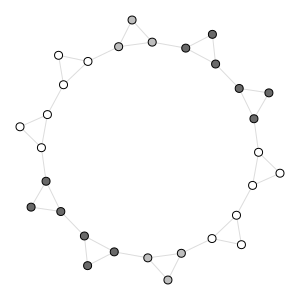

In [32]:
## Leiden communities with 10 3-cliques
roc = ringOfCliques(n=10, s=3)
roc.vs['le'] = roc.community_leiden(objective_function='modularity').membership
roc.vs['color'] = [cls[x%3] for x in roc.vs['le']]
#ig.plot(roc,'ring_3_q.eps', bbox=(0,0,300,300))
ig.plot(roc,bbox=(0,0,300,300))

Why is ECG solving this problem? It is due to the first step, where we run an ensemble of level-1 Louvain and assign new weights to edges based on the proportion of times those edges are internal to a community.

We see below that there are exactly 30 edges with maximal edge weight of 1 (edges within cliques) and 10 edges with default minimal weight of 0.05 (edges between cliques). 

With those new weights, the last clustering in ECG can easily recover the cliques as communities.


In [33]:
## ECG weights in this case: all 30 clique edges have max score
roc.es['W'] = roc.community_ecg().W
Counter(roc.es['W'])

Counter({1.0: 30, 0.05: 10})

# Ego nets and more

Suppose we want to look at the node that are *near* some seed node $v$. 

One common way to do this is to look at its ego-net, i.e. the subgraph consisting of node $v$ and all other nodes that can be reached from $v$ in $k$ hops or less, where $k$ is small, typically 1 or 2. 

Such subgraphs can become large quickly as we increase $k$. In the cells below, we look at ego-nets and compare with another approach to extract subgraph(s) around $v$ via clustering.

We consider the **airport** graph we already saw several times. We consider a simple, undirected version (no loops, directions or edge weights).

We compare ego-nets (1 and 2-hops subgraphs from a given node) with clusters obtained via graph clustering for some vertex $v$ (airport 'MQT') which has degree 11 (you can try other vertices).

In [34]:
## read edges and build simple undirected graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
g = g.as_undirected()
g = g.simplify()

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]

## add a few more attributes for visualization
g.vs()['size'] = 8
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
df = A.head()

## pick a vertex v
v = 207
print(g.vs[v])
print('vertex degree:',g.degree()[v])
g.vs[v]['color'] = 'black'


igraph.Vertex(<igraph.Graph object at 0x14d4fbd50>, 207, {'name': 'MQT', 'layout': (-87.395401001, 46.3535995483), 'state': 'MI', 'city': 'Marquette', 'size': 8, 'color': 'gray'})
vertex degree: 11


12 nodes


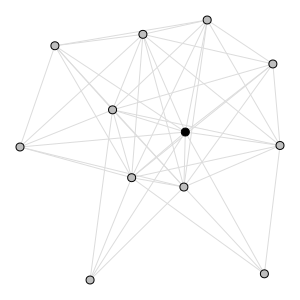

In [35]:
## show its ego-net for k=1 (vertex v shown in black)
sg = g.subgraph([i for i in g.neighborhood(v,order=1)])
print(sg.vcount(),'nodes')
#ig.plot(sg,'airport_ego_1.eps',bbox=(0,0,300,300))
ig.plot(sg,bbox=(0,0,300,300))

221 nodes


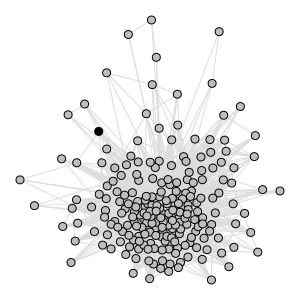

In [36]:
## show its 2-hops ego-net ... this is already quite large!
sg = g.subgraph([i for i in g.neighborhood(v,order=2)])
sg.vs()['core'] = sg.coreness()
sg.delete_vertices([v for v in sg.vs if v['core']<2])
print(sg.vcount(),'nodes')
#ig.plot(sg,'airport_ego_2.eps',bbox=(0,0,300,300))
ig.plot(sg,bbox=(0,0,300,300))

46 nodes


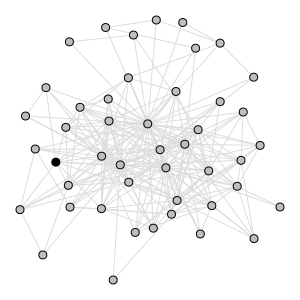

In [37]:
## apply clustering and show the cluster containing the selected vertex
## recall that we ignore edge weights
random.seed(12345) ## seed for the clustering algorithm
np.random.seed(12345) ## seed for the random permutations used
ec = g.community_ecg(ens_size=32)
g.es['W'] = ec.W
m = ec.membership[v]
sg = g.subgraph([i for i in range(g.vcount()) if ec.membership[i]==m])
sg.vs()['core'] = sg.coreness()
## display the 2-core
sg.delete_vertices([v for v in sg.vs if v['core']<2])
print(sg.vcount(),'nodes')
#ig.plot(sg,'airport_ecg.eps',bbox=(0,0,300,300))
ig.plot(sg,bbox=(0,0,300,300))

We see above that looking at the cluster with $v$ is smaller than the 2-hops ego-net, and several nodes are tightly connected.

Below we go further and look at the ECG edge weights, which we can use to prune the graph above, so we can look at the nodes most tightly connected to node $v$.

You can adjust the threshold below to get different zoomings.


18 nodes


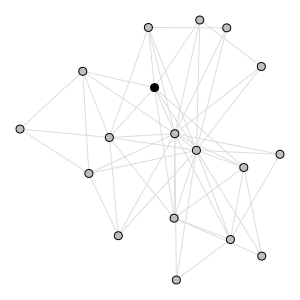

In [38]:
## filter edges w.r.t. ECG votes (weights)
thresh = .85

tmp = sg.subgraph_edges([e for e in sg.es if e['W'] > thresh])
n = [i for i in range(tmp.vcount()) if tmp.vs[i]['color']=='black'][0]
tmp.vs['cl'] = tmp.connected_components().membership
cl = tmp.vs[n]['cl']
ssg = tmp.subgraph([i for i in tmp.vs if i['cl']==cl])
ssg.vs()['core'] = ssg.coreness()
ssg.delete_vertices([v for v in ssg.vs if v['core']<2])
print(ssg.vcount(),'nodes')
#ig.plot(ssg,'airport_ecg_focus.eps',bbox=(0,0,300,300))
ig.plot(ssg, bbox=(0,0,300,300))

Most nodes in this subgraph are from the same state as node $v$ (MI) or nearby state (WI).

In [39]:
## states in the above subgraph
Counter(ssg.vs['state'])

Counter({'MI': 11, 'WI': 6, 'MO': 1})

# EXTRA CODE

The code below requires that Julia and ABCD are installed.


# ABCD Properties

The cells below are for illustration purpose only, to show some ABCD graphs with different $\xi$ (noise) parameters, and to show how you can run ABCD with Julia installed. 

* notice the density of edges between communities as $\xi$ increases.
* most runs should yield 3 communities


In [40]:
## ABCD with varying community strength (xi)
XIs = [.05,.15,.33,.5]

for i in range(len(XIs)):
    xi = XIs[i]
    if i==0:
        ## generate degree and community size values (123 is the seed)
        cmd = julia+' '+abcd_path+'deg_sampler.jl deg.dat 2.5 5 15 100 1000 123'
        os.system(cmd+' >/dev/null 2>&1')
        cmd = julia+' '+abcd_path+'com_sampler.jl cs.dat 1.5 30 50 100 1000 123'
        os.system(cmd+' >/dev/null 2>&1');
    ## gerenate graph given xi
    cmd = julia+' '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat xi '\
            +str(xi)+' false false 123'
    os.system(cmd+' >/dev/null 2>&1')
    g[i] = ig.Graph.Read_Ncol('net.dat',directed=False)
    c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
    ## for plotting - color each community
    g[i].vs['comm'] = [c[int(x['name'])-1]-1 for x in g[i].vs]
    g[i].vs['color'] = [cls[j] for j in g[i].vs['comm']]


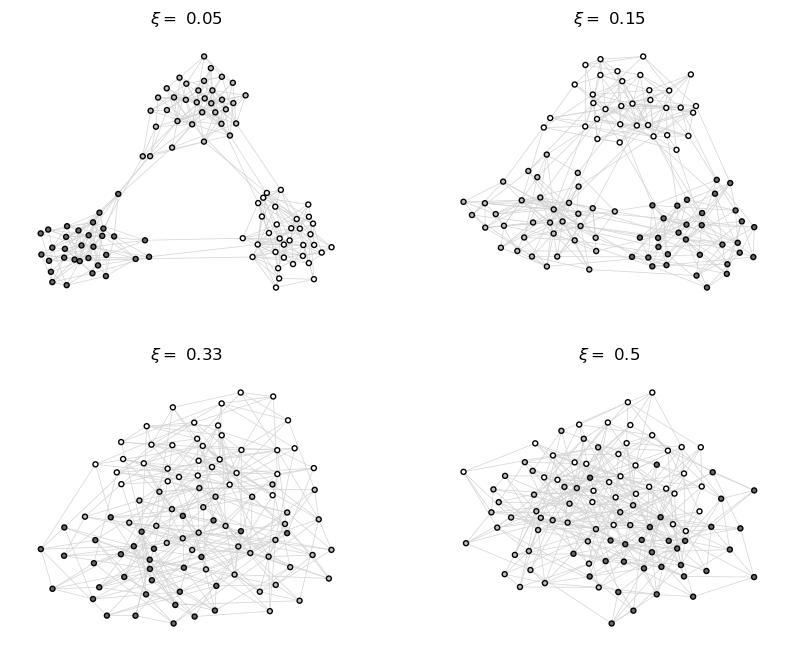

In [41]:
## plot the above graphs
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        ly = g[2*i+j].layout_fruchterman_reingold()
        ig.plot(g[2*i+j], bbox=(0,0,300,300), target=ax, layout=ly,
                vertex_size=5, edge_color='lightgrey', edge_width=0.5)
        ttl = r'$\xi =$ ' + str(XIs[2*i+j])
        ax.set_title(ttl)


## Measures to compare partitions - Figure 5.10

* We illustrate the importance of using proper adjusted measures when comparing partitions; this is why we use AMI (adjusted mutual information) or ARI (adjusted Rand index) in our experiments
* We generate some ABCD graph and compare ground truth with **random** partitions of different sizes
* Scores for random partitions should be close to 0 regardless of the number of parts

In [42]:
## generate degree and community size values
cmd = julia+' '+abcd_path+'deg_sampler.jl deg.dat 2.5 5 50 1000 1000 123'
os.system(cmd+' >/dev/null 2>&1')
cmd = julia+' '+abcd_path+'com_sampler.jl cs.dat 1.5 75 150 1000 1000 123'
os.system(cmd+' >/dev/null 2>&1')

## generate graph with communities
xi = .1
cmd = julia+' '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat xi '\
        +str(xi)+' false false 123'
os.system(cmd+' >/dev/null 2>&1')
g = ig.Graph.Read_Ncol('net.dat',directed=False)

## ground-truth communities
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
gt = [c[int(x['name'])-1]-1 for x in g.vs]
print('number of communities:',np.max(gt)+1)

number of communities: 9


In [43]:
## generate random clusterings and compute various measures w.r.t. ground truth
## this can take a few minutes to run
from sklearn.metrics import mutual_info_score as MI
from sklearn.metrics import rand_score as RI
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI

L = []
n = g.vcount()
tc = {idx:part for idx,part in enumerate(gt)}
ar = np.arange(2,21)
for s in ar:
    for i in range(100):
        r = np.random.choice(s, size=n)
        rd = {idx:part for idx,part in enumerate(r)}        
        L.append([s,MI(gt,r),NMI(gt,r),AMI(gt,r),RI(gt,r),ARI(gt,r),g.gam(tc,rd,adjusted=False),g.gam(tc,rd)])
df = pd.DataFrame(L,columns=['size','MI','NMI','AMI','RI','ARI','GRI','AGRI'])
df_avg = df.groupby(by='size').mean()


Below we show results for 3 measures:
* Mutual information (MI), which has strong bias w.r.t. number of clusters
* Normalized MI (NMI) is better
* AMI is best, no bias w.r.t. number of clusters.

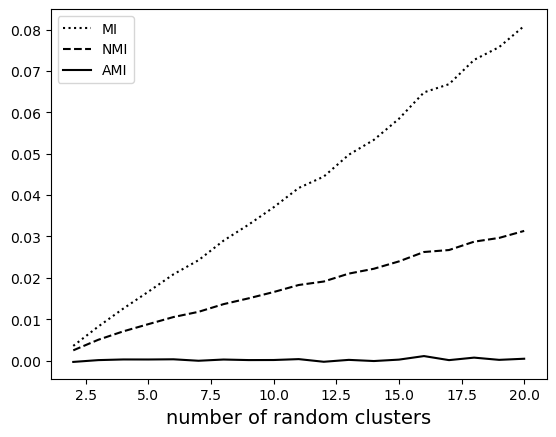

In [44]:
## Mutual information (MI), normalized MI (NMI) and adjusted MI (AMI)
plt.plot(ar, df_avg['MI'],':',color='black',label='MI')
plt.plot(ar, df_avg['NMI'],'--',color='black',label='NMI')
plt.plot(ar, df_avg['AMI'],'-',color='black',label='AMI')
plt.xlabel('number of random clusters',fontsize=14)
plt.legend();
#plt.savefig('MI.eps');


Same below for Rand index (RI) and adjusted version. 

GRI (graph RI) and AGRI (adjusted GRI) are variations of RI specifically for graph data.

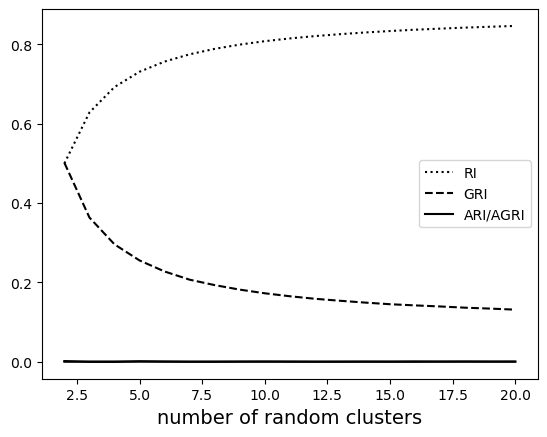

In [45]:
## RAND index (RI) and adjusted (ARI)
## Also: Graph-aware RAND index (GRI) and adjusted version (AGRI)
## those measures are included in "partition-igraph"
## input are partitions of type 'igraph.clustering.VertexClustering'or a dictionaries of node:community.
plt.plot(ar, df_avg['RI'],':',color='black',label='RI')
plt.plot(ar, df_avg['GRI'],'--',color='black',label='GRI')
plt.plot(ar, df_avg['ARI'],'-',color='black',label='ARI/AGRI')
plt.plot(ar, df_avg['AGRI'],'-',color='black')
plt.xlabel('number of random clusters',fontsize=14)
plt.legend();
#plt.savefig('RI.eps');

## Anomaly detection -- American College Football Graph

This is a nice, small graph for illustrating anomaly detection methods.
The graph consists of 115 US college football teams (nodes) playing games (edges).

Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as "anomalies" as can be seen in Figure 5 of [1], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles in plot below)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles in plot below) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles below)

[1]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799



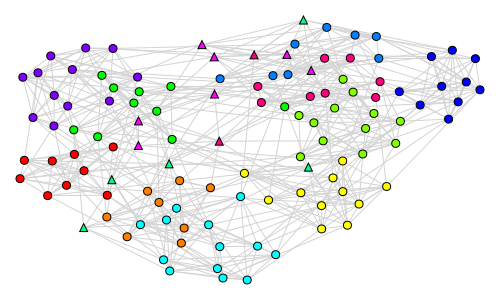

In [46]:
## read graph and communities
cfg = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
cfg.vs['community'] = [c[int(x['name'])] for x in cfg.vs]

## plot the College Football Graph
## show communities in dfferent colors
## show known anomalies as triangles
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(cfg.vs['community'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['community']]
for v in cfg.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ly = cfg.layout_fruchterman_reingold()
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


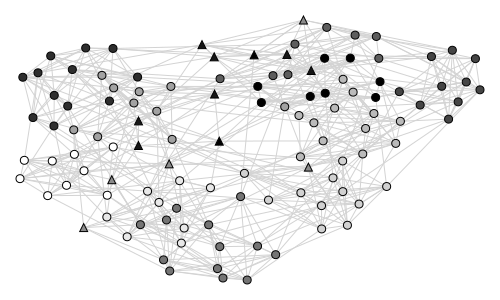

In [47]:
## greyscale version (for the book)
pal = ig.GradientPalette("white","black",max(cfg.vs['community'])+1)
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['community']]
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')
#ig.plot(cfg, target="foot.eps", layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')

### Anomaly detection

We apply some of the community-based measures we defined earlier to find the *anomalous* nodes, namely looking at:

* the participation coefficient (pc) - high values are indicative of anomalous nodes
* the community association strength (cas) - low values are indicative of anomalous nodes
* the community distribution distance (cdd)- low values are indicative of anomalous nodes

The rationale is that an *anomalous* node will be difficult to place in a single cluster.
In the plot below, we show the distribution of those scores amongst the anomalous and non-anomalous nodes respecvively.
For the communities, we use the results from the ECG algorithm rather than using the ground-truth communities.

We also show the ROC curves for each measure and compute the AUC (area under the ROC curve), 
A ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold value.
The area unde rthe ROC curve, the AUC, can be interpreted as the probability that a randomly chosen positive case has a higher 
score than a randomly chosen negative case.


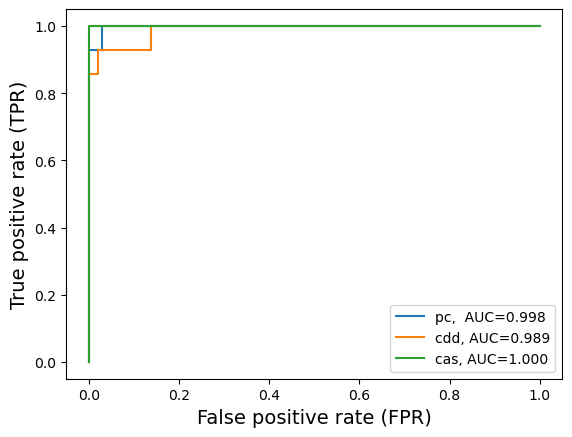

In [48]:
random.seed(123)
cfg_comm = cfg.community_ecg(final='leiden').membership
ROC_cdd = roc_curve(cfg.vs['anomaly'], 1-np.array(cdd(cfg,cfg_comm)))
ROC_cas = roc_curve(cfg.vs['anomaly'], 1-np.array(cas(cfg,cfg_comm)))
ROC_pc = roc_curve(cfg.vs['anomaly'], np.array(pc(cfg,cfg_comm)))
AUC_cdd = roc_auc_score(cfg.vs['anomaly'], 1-np.array(cdd(cfg,cfg_comm)))
AUC_cas = roc_auc_score(cfg.vs['anomaly'], 1-np.array(cas(cfg,cfg_comm)))
AUC_pc = roc_auc_score(cfg.vs['anomaly'], np.array(pc(cfg,cfg_comm)))

plt.plot(ROC_pc[0],ROC_pc[1], label='pc,  AUC='+"{:.3f}".format(AUC_pc))
plt.plot(ROC_cdd[0],ROC_cdd[1], label='cdd, AUC='+"{:.3f}".format(AUC_cdd))
plt.plot(ROC_cas[0],ROC_cas[1], label='cas, AUC='+"{:.3f}".format(AUC_cas))
plt.legend()
plt.xlabel('False positive rate (FPR)', fontsize=14)
plt.ylabel('True positive rate (TPR)', fontsize=14);


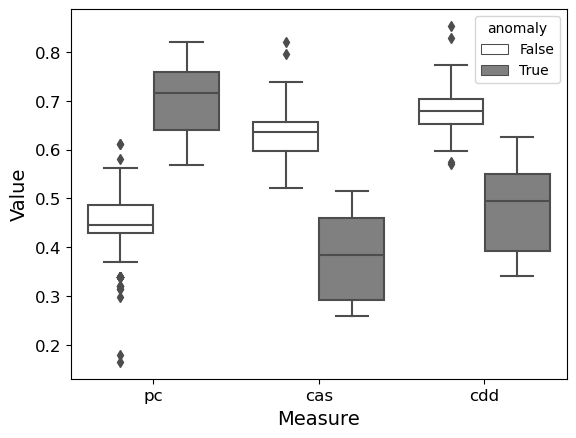

In [49]:
## build dataframe with community-based features
n = cfg.vcount()
df = pd.DataFrame()
df['measure'] = np.concatenate((np.repeat('pc',n), np.repeat('cas',n), np.repeat('cdd',n)))
df['value'] = np.concatenate((np.array(pc(cfg,cfg_comm)), np.array(cas(cfg,cfg_comm)), np.array(cdd(cfg,cfg_comm))))
df['anomaly'] = np.concatenate((np.array(cfg.vs['anomaly'])==1,np.array(cfg.vs['anomaly'])==1,np.array(cfg.vs['anomaly'])==1))

## boxplots
bp = sns.boxplot(data=df, x='measure', y='value', hue='anomaly', palette=cls);
bp.set_xlabel("Measure", fontsize=14)
bp.set_ylabel("Value", fontsize=14)
bp.tick_params(labelsize=12)
plt.show()
#plt.savefig('anomalies_foot.eps');


In [50]:
## clean up
cmd = 'rm deg.dat cs.dat net.dat comm.dat'
os.system(cmd+' >/dev/null 2>&1');
